In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03ff\u1f00-\u1fff]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"
            else:
                for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                    match = re.search(regex_pattern, text)
                    if match:
                        pred = lang_code
                        break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
48930,other,蜻蜓点水的一本书，很多话题都流于概念。有点失望。
71229,other,وردد مستشارون آخرون هذا القلق.
77725,other,书尚可。但亚马逊的支付功能实在太烂，kindle银行卡、支付宝都不能直接支付，这样下去可不敢...
21789,other,"पिछले अध ् याय में , हमने उदाहरण का चयन किया ."
86561,other,"""Fast &amp; Furious"" gwiazda Paul Walker ginie..."
...,...,...
55995,other,粒が10円玉くらいあり、 大きくて小型犬には食べにくそうでした。 缶詰と混ぜても残すようにな...
88850,other,La risposta a questa e a tutte queste domande ...
5546,other,声音好大，而且我要求开发票了，为什么没有收到发票
17366,other,USA wnosi sprawę o podjęcie działań przeciwko ...


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,粒が10円玉くらいあり、 大きくて小型犬には食べにくそうでした。 缶詰と混ぜても残すようにな...
23996,other,La risposta a questa e a tutte queste domande ...
23997,other,声音好大，而且我要求开发票了，为什么没有收到发票
23998,other,USA wnosi sprawę o podjęcie działań przeciwko ...


### Greek-Greeklish identification dataset

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.crawling import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.51it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.57it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.51it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.49it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.20it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.42it/s]


Processing page 7 of 8...


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  4.87it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.31it/s]


Processing page 8 of 8...


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:01<00:00,  5.30it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.51it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

415

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [17]:
warmane_df = warmane_df[~empty_contents]

C:\Users\user\AppData\Local\Temp\ipykernel_42048\4208840340.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  warmane_df = warmane_df[~empty_contents]


In [20]:
from src.crawling import ChromeDriverManager, jupyter_options


ChromeDriverManager.set_options(jupyter_options())

In [21]:
from tasks.youtube import extract_search_results, extract_comments, scrape_youtube


greek_yt_urls = ["https://www.youtube.com/watch?v=4Y2gxkqbsbA", 
       "https://www.youtube.com/watch?v=31LcJ9gqQvA",
       "https://www.youtube.com/watch?v=1cZXAQ1JEJo",
       "https://www.youtube.com/watch?v=x7lnS6jMS64",
       "https://www.youtube.com/watch?v=ImilczGN-00"]
scrape_results = []

for url in greek_yt_urls:
    scrape_results.append(scrape_youtube(ChromeDriverManager.get(), url, max_scrolls=10, verbose=False))

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...
Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...
Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...
Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...
Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [22]:
from tasks.youtube import extract_comments


all_comments = []
for result in scrape_results:
    comments, _ = extract_comments(result)
    all_comments += comments

all_comments = pd.Series(all_comments)

In [23]:
greeklish_series = pd.concat([warmane_df.contents, all_comments])
greeklish_series

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
                                 ...                        
456                                                   Πρώτος
457                                                    Πρώτη
458                                                    First
459                                             First of all
460                                                   Πρώτος
Length: 869, dtype: object

In [24]:
conditions = (greeklish_series.apply(lambda x: len(x) != 0)) & \
                (greeklish_series.apply(lambda x: "RRR" not in x)) & \
                (greeklish_series.apply(lambda x: "PPP" not in x)) & \
                (greeklish_series.apply(lambda x: "First" not in x))
cleared_greeklish_series = greeklish_series[conditions]
cleared_greeklish_series

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
                                 ...                        
454                                               Πρώτο like
455                                        Gianni παίξε Pubg
456                                                   Πρώτος
457                                                    Πρώτη
460                                                   Πρώτος
Length: 860, dtype: object

In [25]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(cleared_greeklish_series)

In [26]:
cleared_greeklish_series[preds=="greeklish"]

Series([], dtype: object)

In [27]:
cleared_greeklish_series[preds=="en"]

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
439                                                 5:23 RIP
446        Ante Pali me ta atoma pou einai first.... Mhn ...
447                                                      Lol
449                                             na xanapexis
453                                                     Hafa
Length: 317, dtype: object

In [28]:
cleared_greeklish_series[preds=="el"]

2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
454                                               Πρώτο like
455                                        Gianni παίξε Pubg
456                                                   Πρώτος
457                                                    Πρώτη
460                                                   Πρώτος
Length: 542, dtype: object

In [29]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": cleared_greeklish_series})
gold2_df

,labels,text
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
454,el,Πρώτο like
455,el,Gianni παίξε Pubg
456,el,Πρώτος
457,el,Πρώτη


In [30]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
454,el,Πρώτο like
455,el,Gianni παίξε Pubg
456,el,Πρώτος
457,el,Πρώτη


In [31]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file)
    print(f"File saved successfully as {file}")

In [32]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [38]:
from tasks.youtube import extract_search_results, extract_comments


# "greek songs" search in Greek
song_search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), song_search_url, max_scrolls=5, verbose=True)
results_search_song = extract_search_results(search_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [39]:
gaming_search_url = "https://www.youtube.com/results?search_query=greek+fortnite"
gaming_soup = scrape_youtube(ChromeDriverManager.get(), gaming_search_url, max_scrolls=5, verbose=True)
results_search_gaming = extract_search_results(gaming_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [40]:
results_df = pd.DataFrame({"title": results_search_song[0] + results_search_gaming[0],
                           "link":  results_search_song[1] + results_search_gaming[1]})
results_df

,title,link
0,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...
1,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...
2,\n\nΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Που...,/watch?v=C4f3xcZzr3s&pp=ygUjzrXOu867zrfOvc65zr...
3,\n\nΤα Λαϊκά Της Ταβέρνας - Ta Laika Tis Taver...,/watch?v=DqKTdn8Krx0&pp=ygUjzrXOu867zrfOvc65zr...
4,\n\nΜουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χ...,/watch?v=p5g82ta4sTk&pp=ygUjzrXOu867zrfOvc65zr...
...,...,...
268,\n\n🔴Η ΝΕΑ SEASON OG ΕΙΝΑΙ ΕΔΩ! | FORTNITE | S...,/watch?v=M0S0345Wwzg&pp=ygUOZ3JlZWsgZm9ydG5pdG...
269,\n\nΜΑΝΤΕΨΕ ΠΟΥ ΕΙΣΑΙ ΣΤΟ FORTNITE GEOGUESSR!\n,/watch?v=SEpE_i05_Zc&pp=ygUOZ3JlZWsgZm9ydG5pdG...
270,\n\nNO BUILDING ΘΑ ΜΕΙΝΕΙ ΓΙΑ ΠΑΝΤΑ (Fortnite ...,/watch?v=qqbNZ3xhQF4&pp=ygUOZ3JlZWsgZm9ydG5pdG...
271,\n\nΗΡΘΕ ΤΟ HALLOWEEN ΣΤΟ FORTNITE ft W1ndz\n,/watch?v=rJabqwE75Ig&pp=ygUOZ3JlZWsgZm9ydG5pdG...


In [41]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
1,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...
2,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...
3,Τα Λαϊκά Της Ταβέρνας - Ta Laika Tis Tavernas ...,https://www.youtube.com/watch?v=DqKTdn8Krx0&pp...
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
...,...,...
268,🔴Η ΝΕΑ SEASON OG ΕΙΝΑΙ ΕΔΩ! | FORTNITE | SAC :...,https://www.youtube.com/watch?v=M0S0345Wwzg&pp...
269,ΜΑΝΤΕΨΕ ΠΟΥ ΕΙΣΑΙ ΣΤΟ FORTNITE GEOGUESSR!,https://www.youtube.com/watch?v=SEpE_i05_Zc&pp...
270,NO BUILDING ΘΑ ΜΕΙΝΕΙ ΓΙΑ ΠΑΝΤΑ (Fortnite Greek),https://www.youtube.com/watch?v=qqbNZ3xhQF4&pp...
271,ΗΡΘΕ ΤΟ HALLOWEEN ΣΤΟ FORTNITE ft W1ndz,https://www.youtube.com/watch?v=rJabqwE75Ig&pp...


In [42]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
2,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...
3,Τα Λαϊκά Της Ταβέρνας - Ta Laika Tis Tavernas ...,https://www.youtube.com/watch?v=DqKTdn8Krx0&pp...
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
8,Τα λαϊκά που αγαπήσαμε - 100 ιστορικά τραγούδι...,https://www.youtube.com/watch?v=OuY-cviIIqM&pp...
...,...,...
268,🔴Η ΝΕΑ SEASON OG ΕΙΝΑΙ ΕΔΩ! | FORTNITE | SAC :...,https://www.youtube.com/watch?v=M0S0345Wwzg&pp...
269,ΜΑΝΤΕΨΕ ΠΟΥ ΕΙΣΑΙ ΣΤΟ FORTNITE GEOGUESSR!,https://www.youtube.com/watch?v=SEpE_i05_Zc&pp...
270,NO BUILDING ΘΑ ΜΕΙΝΕΙ ΓΙΑ ΠΑΝΤΑ (Fortnite Greek),https://www.youtube.com/watch?v=qqbNZ3xhQF4&pp...
271,ΗΡΘΕ ΤΟ HALLOWEEN ΣΤΟ FORTNITE ft W1ndz,https://www.youtube.com/watch?v=rJabqwE75Ig&pp...


In [43]:
from tasks.youtube import scrape_youtube
import concurrent.futures
import threading
import bs4
import random

from src.crawling import _new_chrome_driver


def concurrent_youtube_scrape(n_jobs:int, yt_urls: list[str]):
    split_yt_urls = [chunk(yt_urls, n_jobs) for i in range(n_jobs)]
    
    print("Starting scraping...")
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_jobs) as executor:
        scrape_results = list(tqdm(executor.map(scrape_job, split_yt_urls), total=len(yt_urls)))
    
    return scrape_results


def scrape_job(yt_urls: list[str]) -> tuple[str, bs4.BeautifulSoup]:
    driver = _new_chrome_driver(jupyter_options())
    return_urls, return_soups = [], []
    for yt_url in yt_urls:
        try:
            result = scrape_youtube(driver, 
                                    yt_url[0], 
                                    scroll_wait_secs=2,
                                    max_scrolls=15,
                                    verbose=False)
            return_urls.append(url)
            return_soups.append(result)
        except Exception as e:
            print(e)
            print("a", sep=",")
            continue
    driver.quit()
    return return_urls, return_soups


def chunk(xs, n):
    ys = list(xs)
    random.shuffle(ys)
    chunk_length = len(ys) // n
    needs_extra = len(ys) % n
    start = 0
    for i in range(n):
        if i < needs_extra:
            end = start + chunk_length + 1
        else:
            end = start + chunk_length
        yield ys[start:end]
        start = end

In [47]:
from selenium.common.exceptions import JavascriptException


jobs = 5
# get at most max_videos, if more videos were crawled during the search
max_videos = 60
urls = gr_res_df.link.sample(max_videos) if len(gr_res_df.link) > max_videos else gr_res_df.link

#concurrent_youtube_scrape(jobs, urls)
scrape_results = []

print("Scraping videos...")
for url in tqdm(urls):
    try:
        scrape_results.append((url, scrape_youtube(ChromeDriverManager.get(), url, max_scrolls=10, scroll_wait_secs=1.3, verbose=False)))
    except JavascriptException:
        continue
    except Exception as e:
        print(e)
        continue        

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [14:45<00:00, 14.76s/it]


In [48]:
ChromeDriverManager.quit()

In [53]:
scraped_urls = []
comments = []
dates = []

print("Processing comments...")
for url, result in tqdm(scrape_results):
    if result is not None:
        new_comments, new_dates = extract_comments(result)
        comments += new_comments
        dates += new_dates
        scraped_urls += ([url] * len(new_comments))

print(f"Processed {len(comments)} videos with comments, {len(scrape_results) - len(comments)} empty .")

Processing comments...


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:30<00:00,  1.89it/s]

Processed 6867 videos with comments, -6809 empty .


In [58]:
comments_df = pd.DataFrame({"link": url, "text": comments, "date": dates})
comments_df

,link,text,date
0,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Εαν σας άρεσε κάντε Like ρεεε μη ντρέπεστε!\n+...,2019-11-26 15:09:44.721211
1,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Φήμες λένε ότι ο Gianuba βάζει καρδούλες ️,2019-11-26 15:09:44.726241
2,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,"Congrats on your channel , que venha o 1 milh...",2019-11-26 15:09:44.730226
3,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,ΤΟΣΑ ΤΕΛΕΙΑ ΒΙΝΤΕΟ ΘΑ ΚΑΝΕΙ Ο GIANOUBA22\n\n\n\n,2019-11-26 15:09:44.733731
4,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Η φάση που ο gianuba 22 φοράει μπλούζα pdt nue...,2019-11-26 15:09:44.737730
...,...,...,...
6862,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Λιγότερο απο 1 ωρα \n,2023-11-24 15:10:15.224000
6863,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Πολλά μποτάκια μιλάμε,2023-11-25 21:10:15.227967
6864,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Lol,2023-11-24 15:10:15.231001
6865,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,πλισ κανε καρδουλα,2023-11-25 15:10:15.235969


In [59]:
comments_df.date = comments_df.date.apply(lambda x: x.date() if x is not None else None)

preds = greeklish_model.predict(comments_df.text)
mask = ((preds != "el") & (preds != "greeklish"))
comments_df[mask]

,link,text,date
2,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,"Congrats on your channel , que venha o 1 milh...",2019-11-26
14,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Giannuba for ever️️️,2019-11-26
15,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,O kaliteros eise mpravo,2019-11-26
62,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,eisai oti kalitero bro se latrebo,2019-11-26
76,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Giati kanete live sto facebook kai oxi sto yt?...,2019-11-26
...,...,...,...
6823,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,hi,2023-11-05
6843,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,37 fatalities from teleiutaio to metrises,2023-11-25
6845,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,W1ndz on top,2023-11-25
6846,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,37 kills htan to teleiutaio den to metrises,2023-11-24


In [60]:
crawl_df = pd.merge(gr_res_df, comments_df, how="inner", on="link")
crawl_df

,title,link,text,date
0,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Εαν σας άρεσε κάντε Like ρεεε μη ντρέπεστε!\n+...,2019-11-26
1,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Φήμες λένε ότι ο Gianuba βάζει καρδούλες ️,2019-11-26
2,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,"Congrats on your channel , que venha o 1 milh...",2019-11-26
3,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,ΤΟΣΑ ΤΕΛΕΙΑ ΒΙΝΤΕΟ ΘΑ ΚΑΝΕΙ Ο GIANOUBA22\n\n\n\n,2019-11-26
4,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Η φάση που ο gianuba 22 φοράει μπλούζα pdt nue...,2019-11-26
...,...,...,...,...
6862,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Λιγότερο απο 1 ωρα \n,2023-11-24
6863,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Πολλά μποτάκια μιλάμε,2023-11-25
6864,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Lol,2023-11-24
6865,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,πλισ κανε καρδουλα,2023-11-25


In [61]:
sum(crawl_df.date == None)

0

## Language Identification

https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he
https://gking.harvard.edu/files/abs/0s-abs.shtml
https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data


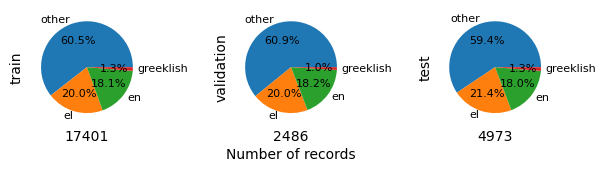

In [62]:
from src.ml import train_test_val_split
import matplotlib.pyplot as plt


data_train, data_val, data_test = train_test_val_split(gold_df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2,
                                                        random_state=42, stratify_col="labels")
# code block from Ioannis Pavlopoulos
axes = pd.DataFrame({"train": data_train.labels.value_counts(),
              "validation": data_val.labels.value_counts(),
              "test": data_test.labels.value_counts()}
            ).plot.pie(subplots=True, 
                       textprops={'fontsize': 8},
                       autopct=f'%1.1f%%', # print percent% results 
                       legend=False)

axes[0].set_xlabel(data_train.shape[0])
axes[1].set_xlabel(data_val.shape[0])
axes[2].set_xlabel(data_test.shape[0])

axes[1].text(0, -2, 'Number of records', ha='center')

plt.tight_layout(pad=2.0)
plt.show()

In [63]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_val = vectorizer.transform(data_val.text)
y_val = data_val.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

In [64]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [65]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.18624605678233438
              precision    recall  f1-score   support

          el       0.00      0.00      0.00      1063
          en       0.00      0.00      0.00       893
   greeklish       0.00      0.00      0.00        65
       other       0.59      1.00      0.74      2952

    accuracy                           0.59      4973
   macro avg       0.15      0.25      0.19      4973
weighted avg       0.35      0.59      0.44      4973



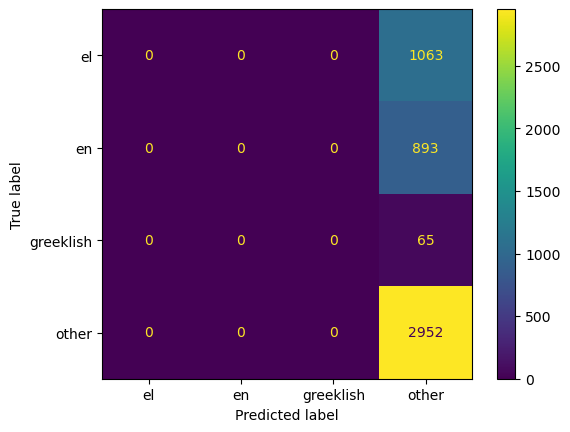

In [66]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [67]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.4574, std: 0.4703


Macro F1: 0.4594734321819911
              precision    recall  f1-score   support

          el       1.00      0.70      0.82      1063
          en       0.32      1.00      0.48       893
   greeklish       0.00      0.00      0.00        65
       other       1.00      0.37      0.54      2952

    accuracy                           0.55      4973
   macro avg       0.58      0.52      0.46      4973
weighted avg       0.86      0.55      0.58      4973



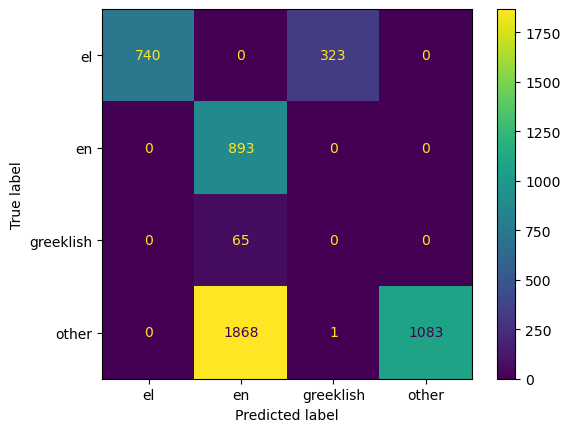

In [68]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8694, std: 0.8282


Macro F1: 0.9090880942266799
              precision    recall  f1-score   support

          el       1.00      0.92      0.96      1063
          en       0.98      0.98      0.98       893
   greeklish       0.97      0.57      0.72        65
       other       0.96      1.00      0.98      2952

    accuracy                           0.97      4973
   macro avg       0.98      0.87      0.91      4973
weighted avg       0.97      0.97      0.97      4973



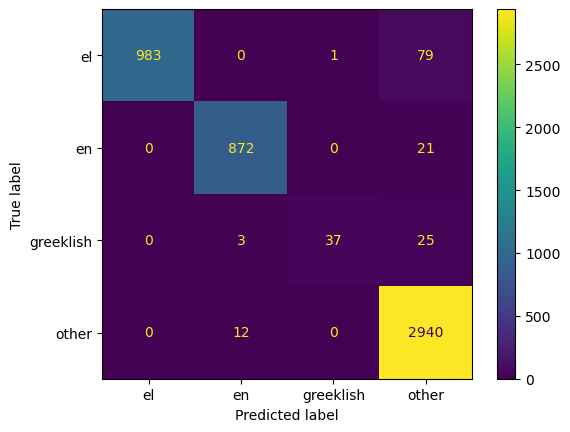

In [70]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

### Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Macro F1: 0.9443963262633673
              precision    recall  f1-score   support

          el       1.00      0.97      0.98      1063
          en       0.97      0.99      0.98       893
   greeklish       0.94      0.74      0.83        65
       other       0.98      0.99      0.99      2952

    accuracy                           0.98      4973
   macro avg       0.97      0.92      0.94      4973
weighted avg       0.98      0.98      0.98      4973



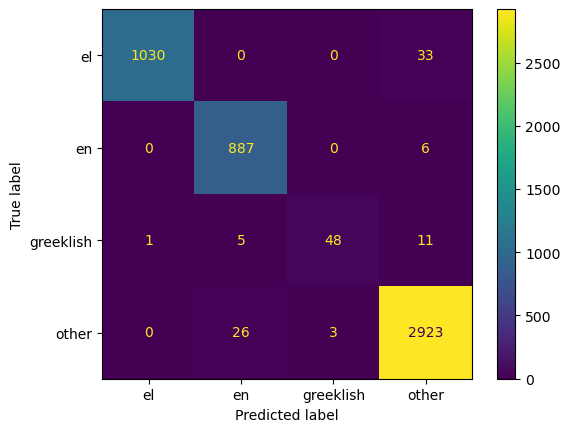

In [71]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

Macro F1: 0.8648698152648873
              precision    recall  f1-score   support

          el       0.99      0.89      0.94      1063
          en       0.98      0.96      0.97       893
   greeklish       0.83      0.45      0.58        65
       other       0.94      0.99      0.97      2952

    accuracy                           0.96      4973
   macro avg       0.94      0.82      0.86      4973
weighted avg       0.96      0.96      0.96      4973



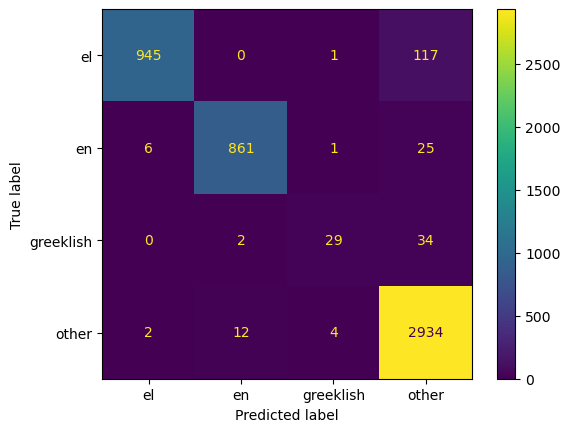

In [72]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [73]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
84,other,el,χαχαχαχα μου θύμισε happy tree friends
450,other,el,Λες?
1808,other,el,Αναστήσει όλους τους προέδρους .
166,other,greeklish,"02:30 ez 1v5,Rito?? Need udyr pls"
427,other,el,3:38 εδώ κλαψει
...,...,...,...
448,other,el,Παιξε pubg
9872,en,other,I didn ' t notice it duu-duu
3100558,other,greeklish,80lvl Beast master Hunter pros to paron 3.5 G...
15926,el,other,Oooh see yeah well if u like beetlejuice you '...


In [74]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
450,other,el,Λες?
427,other,el,3:38 εδώ κλαψει
17825,en,other,Uh-huh vizuri i guess the only people i ' ve n...
69,other,el,Η δουλεία μειώνεται
90,other,greeklish,finally tear drops
...,...,...,...
448,other,el,Παιξε pubg
9872,en,other,I didn ' t notice it duu-duu
3100558,other,greeklish,80lvl Beast master Hunter pros to paron 3.5 G...
15926,en,other,Oooh see yeah well if u like beetlejuice you '...


### Hyperparameter tuning

In [75]:
estimators = []
scores = []

for n_estimators in tqdm([int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]):
    estim = RandomForestClassifier(n_estimators=n_estimators, 
                                  n_jobs=-1, 
                                  criterion="entropy").fit(x_train, y_train)
    score = f1_score(y_val, estim.predict(x_val), average='macro', zero_division=0)

    estimators.append(estim)
    scores.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:02<00:00, 96.49s/it]


In [76]:
best_model = estimators[np.argmax(scores)]
print(f"Best model {best_model} with macro F1 score of {max(scores)}")

Best model RandomForestClassifier(criterion='entropy', n_estimators=325, n_jobs=-1) with macro F1 score of 0.9564126002840819


### Annotating the operational dataset

In [77]:
x_oper = vectorizer.transform(crawl_df.text)
crawl_df["language"] = best_model.predict(x_oper)

In [78]:
crawl_df

,title,link,text,date,language
0,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Εαν σας άρεσε κάντε Like ρεεε μη ντρέπεστε!\n+...,2019-11-26,el
1,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Φήμες λένε ότι ο Gianuba βάζει καρδούλες ️,2019-11-26,el
2,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,"Congrats on your channel , que venha o 1 milh...",2019-11-26,other
3,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,ΤΟΣΑ ΤΕΛΕΙΑ ΒΙΝΤΕΟ ΘΑ ΚΑΝΕΙ Ο GIANOUBA22\n\n\n\n,2019-11-26,el
4,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Η φάση που ο gianuba 22 φοράει μπλούζα pdt nue...,2019-11-26,el
...,...,...,...,...,...
6862,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Λιγότερο απο 1 ωρα \n,2023-11-24,other
6863,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Πολλά μποτάκια μιλάμε,2023-11-25,other
6864,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,Lol,2023-11-24,greeklish
6865,Σηκώσαμε 36 KILLS Στο OG FORTNITE!,https://www.youtube.com/watch?v=fjWNWl5l-bg&pp...,πλισ κανε καρδουλα,2023-11-25,other


In [79]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


### Exploring the operational dataset

In [80]:
RESOURCE_OUTPUT = "results"

def save_plot(filename):
    path = os.path.join(RESOURCE_OUTPUT, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

Figured saved to results\lang_dis.png


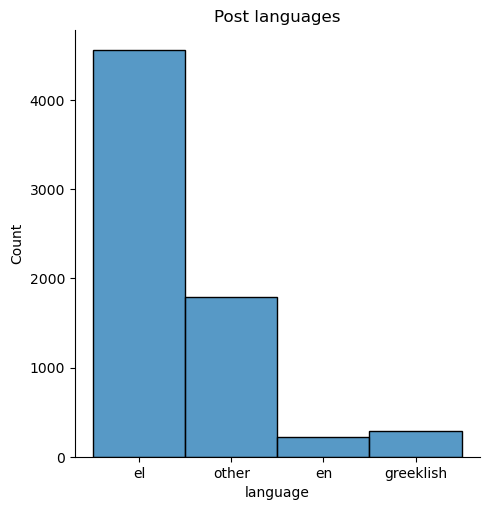

In [81]:
import seaborn as sns


sns.displot(crawl_df.language)
save_plot("lang_dis.png")
plt.title("Post languages")
plt.show()

In [92]:
languages = np.unique(crawl_df.language)

lang_col = []
len_col = []

for language in languages:
    comments_text = crawl_df.loc[crawl_df.language == language, "text"]
    comments_length = comments_text.apply(lambda x: len(x))
    
    lang_col += [language] * len(comments_length)
    len_col += list(comments_length)

len_df = pd.DataFrame({"language": lang_col, "comment_length": len_col})

Figured saved to results\length_dis.png


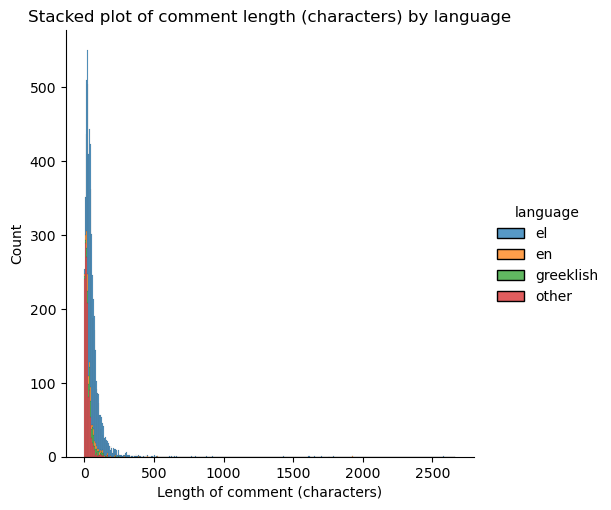

In [93]:
sns.displot(len_df, x="comment_length", hue="language", multiple="stack")
plt.title("Stacked plot of comment length (characters) by language")
plt.xlabel("Length of comment (characters)")
save_plot("length_dis.png")
plt.show()

In [89]:
len_df.iloc[np.argmax(len_df.comment_length)]

language            el
comment_length    2664
Name: 661, dtype: object

In [84]:
emoji_pattern = re.compile(
    r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF'
    r'\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF'
    r'\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\u2600-\u26FF\u2700-\u27BF'
    r'\u2B50\u2B06\u2934\u2935\u2B05\u2194-\u2199\u21A9\u21AA\u2139\u2328'
    r'\u23CF\u23E9-\u23F3\u231A\u23F8-\u23FA\u231B\u23F0\u231A\u1F004'
    r'\u1F0CF\u1F18E\u3030\u303D]'
)

emojis_col = []

for language in languages:
    comments_text = crawl_df.loc[crawl_df.language == language, "text"]
    comments_length = comments_text.apply(lambda x: len(emoji_pattern.findall(x)))

    emojis_col += list(comments_length)

emoji_df = pd.DataFrame({"language": lang_col, "emojis": emojis_col})

Figured saved to results\emojis_dis.png


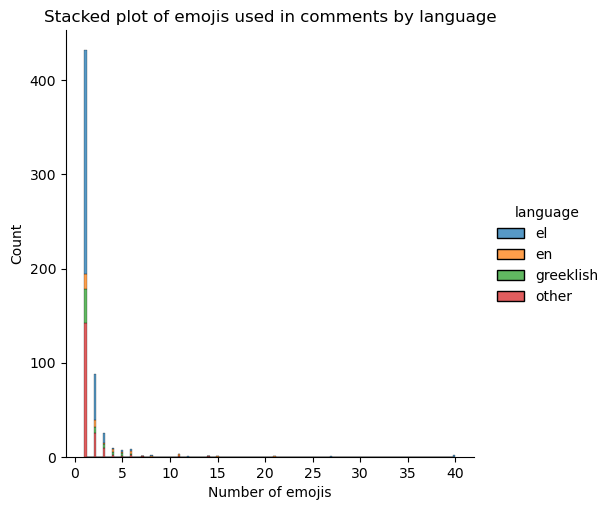

In [85]:
sns.displot(emoji_df[emoji_df.emojis > 0] , x="emojis", hue="language", multiple="stack")
plt.title("Stacked plot of emojis used in comments by language")
plt.xlabel("Number of emojis")
save_plot("emojis_dis.png")
plt.show()

Figured saved to results\time_plot.png


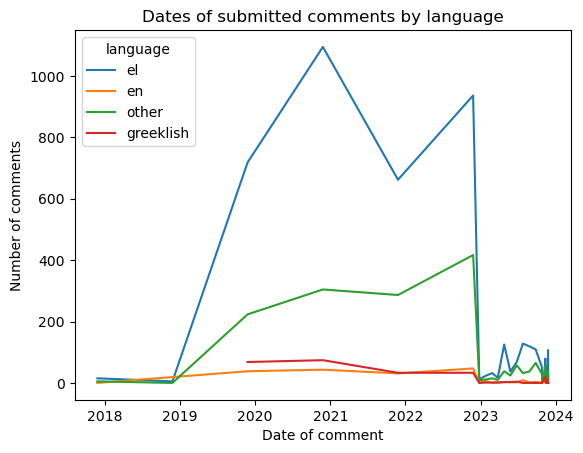

In [87]:
sns.lineplot(x="date", y="text", hue="language", data=date_df)
plt.title("Dates of submitted comments by language")
plt.xlabel("Date of comment")
plt.ylabel("Number of comments")

save_plot("time_plot.png")
plt.show()

In [88]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 40 minutes and 24.5 seconds
